## Time Series Analysis and Forecasting with Python between two Product Categories

Time series are widely used for non-stationary data, like economic, weather, stock price, and retail sales in this post. We will demonstrate different approaches for forecasting retail sales time series. Let’s get started!

Dataset ref: https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls
<p>Goal: Time Series Analysis and Forecasting with Python using Superstore Sales Data for Technology and Office Supplies Category. </p> <><>
<p>Skills Covered: Univariate analysis, Multivariate analysis, exploratory data analysis, Time series forecasting with ARIMA, Grid Search, Data Visualization</p>

Data pipeline procedure using Python:

### 1. Import the necessary libraries

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib

#setting up default parameters
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('text', color='k')

### <p> 2. Load the data from the source </p>

In [2]:
df = pd.read_excel("Superstore.xls")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


## Time Series of Technology vs. Office Supplies
According to our data, there were way more number of sales from Office Supplies than from Furniture over the years.

In [4]:
office = df.loc[df['Category'] == 'Office Supplies']
tech = df.loc[df['Category'] == 'Technology']
office.shape, tech.shape

((6026, 21), (1847, 21))

## Data Exploration
We are going to compare two categories’ sales in the same time period. This means combine two data frames into one and plot these two categories’ time series into one plot.

In [5]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
office.drop(cols, axis=1, inplace=True)
tech.drop(cols, axis=1, inplace=True)
tech = tech.sort_values('Order Date')
office = office.sort_values('Order Date')
tech = tech.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
tech = tech.set_index('Order Date')
office = office.set_index('Order Date')
y_tech = tech['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
tech = pd.DataFrame({'Order Date':y_tech.index, 'Sales':y_tech.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})
### merged dataframe
store = tech.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'tech_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()


,Order Date,tech_sales,office_sales
0,2014-01-01,449.041429,285.357647
1,2014-02-01,229.787143,63.042588
2,2014-03-01,2031.948375,391.176318
3,2014-04-01,613.028933,464.794750
4,2014-05-01,564.698588,324.346545


In [6]:
store.shape

(48, 3)

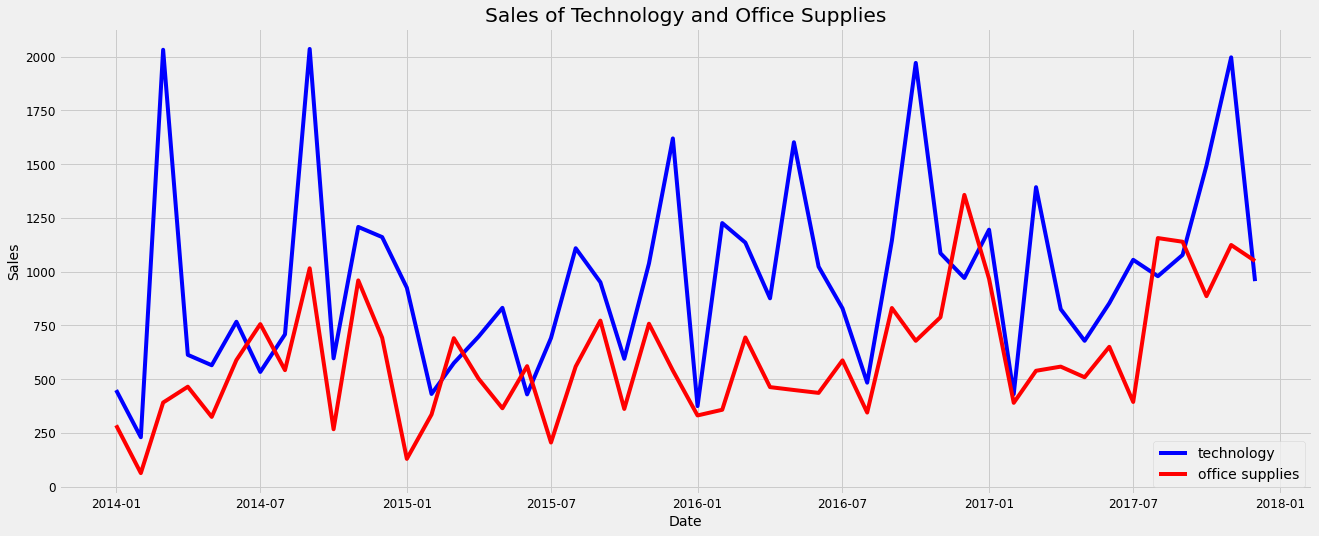

In [8]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['tech_sales'], 'b-', label = 'technology')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Technology and Office Supplies')
plt.legend();

We observe that sales of technology is much higher than office supplies and shared a higher seasonal pattern. For the tech_sales category, we can see that sales tend to be highest in the fall months (September-November), with a smaller peak in January. Sales then drop off in the spring and summer months before picking up again in the fall. For the office_sales category, we can see that sales are relatively consistent throughout the year, with a slight increase in the fall and a slight decrease in the winter months. Overall, it appears that the tech_sales category has a more pronounced seasonality pattern compared to the office_sales category. 

### Let’s find out when was the first time tech sales surpassed those of office supplies’ .

In [11]:
first_date = store.iloc[np.min(list(np.where(store['tech_sales'] > store['office_sales'])[0])), store.columns.get_loc('Order Date')]
print("Tech first time produced higher sales than office supplies is {}.".format(first_date.date()))


Tech first time produced higher sales than office supplies is 2014-01-01.


Office supplies first time produced higher sales than furniture is 2014–01–01.

It was January 2014!

In [9]:
store

,Order Date,tech_sales,office_sales
0,2014-01-01,449.041429,285.357647
1,2014-02-01,229.787143,63.042588
2,2014-03-01,2031.948375,391.176318
3,2014-04-01,613.028933,464.794750
4,2014-05-01,564.698588,324.346545
5,2014-06-01,766.905909,588.774409
6,2014-07-01,533.608933,756.060400
7,2014-08-01,708.435385,541.879143
8,2014-09-01,2035.838133,1015.677704
9,2014-10-01,596.900900,267.078815


In [10]:
store.describe()

,tech_sales,office_sales
count,48.000000,48.000000
mean,967.614885,600.162221
std,450.853309,289.935518
min,229.787143,63.042588
25%,608.996925,383.549413
50%,937.963600,550.054220
75%,1148.310947,761.400438
max,2035.838133,1357.055929


### Observation : Statistical Summary
The table above shows the descriptive statistics of two sales categories - tech_sales and office_sales.
The first row count indicates the number of observations in each category, which is 48 in this case. The second row mean gives the average sales for each category over the entire period. The mean value of tech_sales is 967.61, and the mean value of office_sales is 600.16. This means that on average, the tech_sales category generates more revenue than the office_sales category.

The third row std shows the standard deviation of each category. The standard deviation of tech_sales is 450.85, and the standard deviation of office_sales is 289.94. This indicates that the sales in the tech_sales category are more variable than in the office_sales category.

The fourth row min shows the minimum sales for each category over the period, and the fifth row 25% shows the 25th percentile of sales, which is the point below which 25% of the data falls. The sixth row 50% shows the median, which is the midpoint of the data when arranged in ascending order. The seventh row 75% shows the 75th percentile of sales, which is the point below which 75% of the data falls. Finally, the eighth row max shows the maximum sales for each category over the period.

The descriptive statistics give an overall idea of the sales trends and the variability of each category.